# Using VirtualiZarr with SafeTensors Files

This notebook demonstrates how to use VirtualiZarr to work with SafeTensors files efficiently.

## Setup and Dependencies

First, let's import the necessary libraries:

In [1]:
import os

import matplotlib.pyplot as plt
import torch
from safetensors.torch import save_file

import virtualizarr as vz

%matplotlib inline

## Create a Sample SafeTensors File

Let's create a sample SafeTensors file with different types of tensors:

In [2]:
# Create a directory for our files
os.makedirs("sample_data", exist_ok=True)

# Create tensors of different shapes and types
tensors = {
    "embedding": torch.randn((10000, 7680), dtype=torch.float32),
    "weights": torch.randn((768, 768), dtype=torch.float32),
    "bias": torch.randn(768, dtype=torch.float32),
    "int_values": torch.randint(-100, 100, (50, 50), dtype=torch.int32),
    "bool_mask": torch.rand((100, 100)) > 0.5,
}

# Add metadata
metadata = {
    "model_type": "transformer",
    "created_by": "virtualizarr_example",
    "version": "1.0",
}

# Save to file
filepath = "sample_model.safetensors"
save_file(tensors, filepath, metadata=metadata)
print(f"Created sample file at {filepath}")

Created sample file at sample_model.safetensors


## Open with VirtualiZarr

Now let's open the file using VirtualiZarr:

In [3]:
# Open the file
vds = vz.open_virtual_dataset(filepath)

# Print available tensors
print("Available tensors:")
for name, var in vds.data_vars.items():
    print(f"- {name}: shape={var.shape}, dtype={var.dtype}")

# Print metadata
print("\nMetadata:")
for key, value in vds.attrs.items():
    print(f"- {key}: {value}")

Available tensors:
- bias: shape=(768,), dtype=float32
- embedding: shape=(10000, 7680), dtype=float32
- weights: shape=(768, 768), dtype=float32
- int_values: shape=(50, 50), dtype=int32
- bool_mask: shape=(100, 100), dtype=bool

Metadata:
- version: 1.0
- model_type: transformer
- created_by: virtualizarr_example


## Using Custom Dimension Names

Let's open the file again, but with custom dimension names:

In [4]:
# Define custom dimension names
custom_dims = {
    "embedding": ["token", "feature"],
    "weights": ["input", "output"],
    "bias": ["output"],
}

# Open with custom dimension names
vds_named = vz.open_virtual_dataset(
    filepath, virtual_backend_kwargs={"dimension_names": custom_dims}
)

# Print dimensions
print("Dimensions with custom names:")
for name, var in vds_named.data_vars.items():
    print(f"- {name}: dims={var.dims}")

Dimensions with custom names:
- bias: dims=('output',)
- embedding: dims=('token', 'feature')
- weights: dims=('input', 'output')
- int_values: dims=('int_values_dim_0', 'int_values_dim_1')
- bool_mask: dims=('bool_mask_dim_0', 'bool_mask_dim_1')


## Accessing Parts of Tensors Efficiently

One of the main benefits of VirtualiZarr is the ability to efficiently access parts of tensors:

Shape of extracted slice: (10, 100)
Shape of single token vector: (7680,)


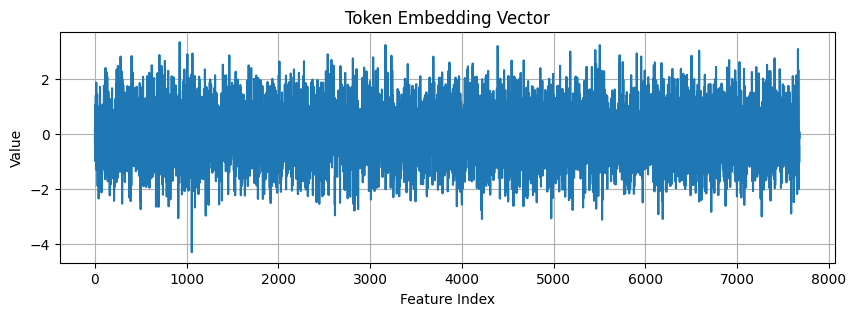

In [5]:
vds = vz.open_virtual_dataset(filepath, loadable_variables=["embedding"])

# Get a slice of the embedding tensor
token_slice = vds["embedding"][100:110, 100:200].values
print(f"Shape of extracted slice: {token_slice.shape}")

# Get a single token embedding
single_token = vds["embedding"][42].values
print(f"Shape of single token vector: {single_token.shape}")

# Visualize the token embedding
plt.figure(figsize=(10, 3))
plt.plot(single_token)
plt.title("Token Embedding Vector")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.grid(True)

In [6]:
import gc

import psutil


def get_memory_usage():
    """Get current memory usage in MB"""
    return psutil.Process().memory_info().rss / (1024 * 1024)


# Memory before loading
mem_before = get_memory_usage()

# Access a small slice
small_slice = vds["embedding"][0:100].values

# Memory after loading a slice
mem_after_slice = get_memory_usage()

# Access the whole tensor
full_tensor = vds["embedding"].values

# Memory after loading the whole tensor
mem_after_full = get_memory_usage()

# Print results
print(f"Memory usage before: {mem_before:.2f} MB")
print(
    f"Memory usage after loading slice: {mem_after_slice:.2f} MB (+ {mem_after_slice - mem_before:.2f} MB)"
)
print(
    f"Memory usage after loading full tensor: {mem_after_full:.2f} MB (+ {mem_after_full - mem_after_slice:.2f} MB)"
)

# Clean up
del small_slice, full_tensor
gc.collect()

Memory usage before: 913.12 MB
Memory usage after loading slice: 916.11 MB (+ 2.98 MB)
Memory usage after loading full tensor: 1209.08 MB (+ 292.97 MB)


3219

**Note:** I'm not entirely sure how this works under-the-hood as we seem to only be retrieving a partial range of the chunk (great! but I didn't do anything to support this...). Should be confirmed by a core dev.

### Not shown

Similar results for remote files on HuggingFace Hub e.g. "https://huggingface.co/openai-community/gpt2/resolve/main/model.safetensors".

## Conclusion

This notebook demonstrated how to use VirtualiZarr with SafeTensors files, including:

1. Opening SafeTensors files as virtual datasets
2. Using custom dimension names for better semantics
3. Efficiently accessing parts of tensors
4. Comparing memory usage

VirtualiZarr provides an efficient way to work with large tensor data, particularly when you only need to access specific parts of the tensors or when working with remote files.